# **Research Question:**
Can material type, age, length, and operational score be used to predict the structural score of a utility pipe?

# **Preparation:**


In [1]:
##Load packages
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [2]:
##Load Data
#dtypes defined for certain columns due to mixed types
data = pd.read_csv('./Mainline_GXPInsp.csv',dtype={"PACPQUICKRATING": object, "GXP_MATERIAL":object, "MATERIALDESCRIPTION":object})

In [3]:
data.tail()

,FACILITYID,DIAMETER,MATERIAL,SHAPELENGTH,SYSTEM,LINENUMBER,MAXSTRUCTURALSCORE,MAXOPSMAINTSCORE,PACPQUICKRATING,MATERIALDESCRIPTION,GXP_MATERIAL,AGE,INSTALLYEAR,SURVEYEDFOOTAGE
100370,83484,0.0,UNK,21,D,30105TT16 301TT16,NaN,NaN,NaN,NaN,NaN,59,1960.0,NaN
100371,83485,0.0,UNK,32,D,30103TT16 301TT16,NaN,NaN,NaN,NaN,NaN,59,1960.0,NaN
100372,83486,0.0,UNK,40,D,42103SS10 421SS10,NaN,NaN,NaN,NaN,NaN,28,1991.0,NaN
100373,83487,0.0,UNK,42,D,70407RR11 704RR11,NaN,NaN,NaN,NaN,NaN,41,1978.0,NaN
100374,83488,0.0,UNK,49,D,70406RR11 704RR11,NaN,NaN,NaN,NaN,NaN,41,1978.0,NaN


In [4]:
print(data.dtypes)
print (data.shape)

FACILITYID               int64
DIAMETER               float64
MATERIAL                object
SHAPELENGTH              int64
SYSTEM                  object
LINENUMBER              object
MAXSTRUCTURALSCORE     float64
MAXOPSMAINTSCORE       float64
PACPQUICKRATING         object
MATERIALDESCRIPTION     object
GXP_MATERIAL            object
AGE                      int64
INSTALLYEAR            float64
SURVEYEDFOOTAGE        float64
dtype: object
(100375, 14)


In [4]:
#Drop pipes that do not have a Max Structural Score
data_mss = data.dropna(subset=['MAXSTRUCTURALSCORE'])
data_mss.shape

(20365, 14)

In [6]:
data_mss.head()

,FACILITYID,DIAMETER,MATERIAL,SHAPELENGTH,SYSTEM,LINENUMBER,MAXSTRUCTURALSCORE,MAXOPSMAINTSCORE,PACPQUICKRATING,MATERIALDESCRIPTION,GXP_MATERIAL,AGE,INSTALLYEAR,SURVEYEDFOOTAGE
0,88498,12.0,UNK,176,D,103CCC21 101CCC21,5.0,0.0,5131,Polypropylene,PP,24,1995.0,179.7
1,88200,12.0,UNK,244,D,217BBB20 234BBB20,5.0,0.0,5141,Concrete pipe (non-reinforced),CP,29,1990.0,246.1
2,88273,12.0,UNK,155,D,101CCC21 304CCC20,5.0,0.0,512A,Polypropylene,PP,24,1995.0,166.1
3,8018,12.0,UNK,244,D,413S16 412S16,5.0,0.0,5200,Reinforced concrete pipe,RCP,40,1979.0,216.3
4,13038,15.0,CMP,0,D,61201S19 612S19,5.0,0.0,5641,Corrugated metal pipe,CMP,0,NaN,34.6


In [6]:
#Dataframe with columns of interest
variables = ['FACILITYID','SYSTEM','DIAMETER', 'MATERIAL','SHAPELENGTH','SURVEYEDFOOTAGE','AGE','MAXOPSMAINTSCORE','MAXSTRUCTURALSCORE']
df = data_mss[variables].copy()

In [7]:
df = df.set_index('FACILITYID')
df.head()

,SYSTEM,DIAMETER,MATERIAL,SHAPELENGTH,SURVEYEDFOOTAGE,AGE,MAXOPSMAINTSCORE,MAXSTRUCTURALSCORE
FACILITYID,,,,,,,,
88498,D,12.0,UNK,176,179.7,24,0.0,5.0
88200,D,12.0,UNK,244,246.1,29,0.0,5.0
88273,D,12.0,UNK,155,166.1,24,0.0,5.0
8018,D,12.0,UNK,244,216.3,40,0.0,5.0
13038,D,15.0,CMP,0,34.6,0,0.0,5.0


In [8]:
#Convert dypes
df[['DIAMETER','MAXOPSMAINTSCORE', 'MAXSTRUCTURALSCORE']] = df[['DIAMETER','MAXOPSMAINTSCORE', 'MAXSTRUCTURALSCORE']].astype(int)

**Null Data**

Diameter, Shape Length, and Age columns have missing values in the form of 0. Separate the rows by system type, then substitute 0's with mean value.

In [9]:
#Count nulls
for col in ['DIAMETER','SHAPELENGTH', 'AGE', 'MAXOPSMAINTSCORE']:
    print (col,' = ',(df[col] == 0).sum())

DIAMETER  =  45
SHAPELENGTH  =  3
AGE  =  702
MAXOPSMAINTSCORE  =  10395


In [11]:
#UPDATE shapelength nulls
test = df[df['SHAPELENGTH']==0]

In [12]:
test.head()

,SYSTEM,DIAMETER,MATERIAL,SHAPELENGTH,SURVEYEDFOOTAGE,AGE,MAXOPSMAINTSCORE,MAXSTRUCTURALSCORE
FACILITYID,,,,,,,,
13038,D,15,CMP,0,34.6,0,0,5
27295,D,0,UNK,0,37.7,0,0,3
29624,D,12,CP,0,138.4,78,0,0


In [13]:
#Get Ids of interest to check later
ids = []
for index, rows in test.iterrows():
    ids.append(index)
print (ids)

[13038, 27295, 29624]


In [14]:
#Update above rows where shapelength==0, use surveyedfootage value
df.loc[df['SHAPELENGTH']==0, 'SHAPELENGTH'] = round(df['SURVEYEDFOOTAGE'])

In [15]:
#Verify changes
df.loc[ids]

,SYSTEM,DIAMETER,MATERIAL,SHAPELENGTH,SURVEYEDFOOTAGE,AGE,MAXOPSMAINTSCORE,MAXSTRUCTURALSCORE
FACILITYID,,,,,,,,
13038,D,15,CMP,35.0,34.6,0,0,5
27295,D,0,UNK,38.0,37.7,0,0,3
29624,D,12,CP,138.0,138.4,78,0,0


In [16]:
#Verify shapelength does not have 0
for col in ['DIAMETER','SHAPELENGTH', 'AGE']:
    print (col,' = ',(df[col] == 0).sum())

DIAMETER  =  45
SHAPELENGTH  =  0
AGE  =  702


In [17]:
#Change shapelength back to int
df.SHAPELENGTH = df.SHAPELENGTH.astype(int)
df.head()

,SYSTEM,DIAMETER,MATERIAL,SHAPELENGTH,SURVEYEDFOOTAGE,AGE,MAXOPSMAINTSCORE,MAXSTRUCTURALSCORE
FACILITYID,,,,,,,,
88498,D,12,UNK,176,179.7,24,0,5
88200,D,12,UNK,244,246.1,29,0,5
88273,D,12,UNK,155,166.1,24,0,5
8018,D,12,UNK,244,216.3,40,0,5
13038,D,15,CMP,35,34.6,0,0,5


In [18]:
df['SYSTEM'].value_counts()

S    10231
C     4704
D     3850
X     1571
Y        9
Name: SYSTEM, dtype: int64

In [19]:
#Divide data by system type
sewer = df[(df['SYSTEM']=='S') | (df['SYSTEM']=='X')].copy()
combined = df[df['SYSTEM']=='C'].copy()
drainage = df[(df['SYSTEM']=='D') | (df['SYSTEM']=='Y')].copy()

In [20]:
#Set up variables in dict
means = dict(dict.fromkeys(["s_Diam", "s_Age", "d_Diam","d_Age","c_Diam","c_Age"], 0))

In [16]:
##Do Not Use. Use Medians.
#Get mean of diameter and age for each system type
for df_system in [sewer, drainage, combined]:
    count = len(df_system)
    diammean = int(round(df_system.DIAMETER.mean()))
    agemean = int(round(df_system.AGE.mean()))
    if df_system.iloc[0].SYSTEM == 'S' or df_system.iloc[0].SYSTEM == 'X':
        s = 'Sewer'
        means['s_Diam'] = diammean
        means['s_Age'] = agemean
    elif df_system.iloc[0].SYSTEM == 'D' or df_system.iloc[0].SYSTEM == 'Y':
        s = 'Drainage'
        means['d_Diam'] = diammean
        means['d_Age'] = agemean
    else:
        s = 'Combined'
        means['c_Diam'] = diammean
        means['c_Age'] = agemean
    print ('{}, For {}, diam mean = {}, age mean = {}'.format(count, s, diammean,agemean))

11802, For Sewer, diam mean = 8, age mean = 58
3859, For Drainage, diam mean = 18, age mean = 46
4704, For Combined, diam mean = 18, age mean = 80


In [21]:
#Get median of diameter and age for each system type
for df_system in [sewer, drainage, combined]:
    count = len(df_system)
    diammean = int(round(df_system.DIAMETER.median()))
    agemean = int(round(df_system.AGE.median()))
    if df_system.iloc[0].SYSTEM == 'S' or df_system.iloc[0].SYSTEM == 'X':
        s = 'Sewer'
        means['s_Diam'] = diammean
        means['s_Age'] = agemean
    elif df_system.iloc[0].SYSTEM == 'D' or df_system.iloc[0].SYSTEM == 'Y':
        s = 'Drainage'
        means['d_Diam'] = diammean
        means['d_Age'] = agemean
    else:
        s = 'Combined'
        means['c_Diam'] = diammean
        means['c_Age'] = agemean
    print ('{}, For {}, diam median = {}, age median = {}'.format(count, s, diammean,agemean))

11802, For Sewer, diam median = 6, age median = 59
3859, For Drainage, diam median = 12, age median = 48
4704, For Combined, diam median = 8, age median = 96


In [22]:
#Zeros per System Type
print ('Zeros in Sewer: Diam = ', len(sewer[sewer['DIAMETER']==0]),' Age = ', len(sewer[sewer['AGE']==0]))
print ('Zeros in Drainage: Diam = ', len(drainage[drainage['DIAMETER']==0]),' Age = ', len(drainage[drainage['AGE']==0]))
print ('Zeros in Combined: Diam = ', len(combined[combined['DIAMETER']==0]),' Age = ', len(combined[combined['AGE']==0]))

Zeros in Sewer: Diam =  0  Age =  69
Zeros in Drainage: Diam =  40  Age =  522
Zeros in Combined: Diam =  5  Age =  111


In [23]:
#Update Sewer Age Values
sewer.loc[sewer['AGE'] == 0 ,'AGE'] = means['s_Age']

In [24]:
#Update Drainage Age and Diameter Values
drainage.loc[drainage['DIAMETER'] == 0 ,'DIAMETER'] = means['d_Diam']
drainage.loc[drainage['AGE'] == 0 ,'AGE'] = means['d_Age']

In [25]:
#Update Combined Age and Diameter Values
combined.loc[combined['DIAMETER'] == 0 ,'DIAMETER'] = means['c_Diam']
combined.loc[combined['AGE'] == 0 ,'AGE'] = means['c_Age']

In [26]:
#Zeros per System Type
print ('Zeros in Sewer: Diam = ', len(sewer[sewer['DIAMETER']==0]),' Age = ', len(sewer[sewer['AGE']==0]))
print ('Zeros in Drainage: Diam = ', len(drainage[drainage['DIAMETER']==0]),' Age = ', len(drainage[drainage['AGE']==0]))
print ('Zeros in Combined: Diam = ', len(combined[combined['DIAMETER']==0]),' Age = ', len(combined[combined['AGE']==0]))

Zeros in Sewer: Diam =  0  Age =  0
Zeros in Drainage: Diam =  0  Age =  0
Zeros in Combined: Diam =  0  Age =  0


In [27]:
result = pd.concat([sewer, drainage,combined])

In [28]:
result.head()

,SYSTEM,DIAMETER,MATERIAL,SHAPELENGTH,SURVEYEDFOOTAGE,AGE,MAXOPSMAINTSCORE,MAXSTRUCTURALSCORE
FACILITYID,,,,,,,,
19341,S,6,VCP,185,20.1,109,0,5
18859,S,6,VCP,258,255.8,47,0,5
20561,S,6,VCP,370,20.6,109,0,5
20035,S,8,VCP,85,46.0,65,0,5
20380,S,6,VCP,296,331.8,6,0,5


In [29]:
result.shape

(20365, 8)

In [30]:
#Double check nulls
for col in ['DIAMETER','SHAPELENGTH', 'AGE']:
    print (col,' = ',(result[col] == 0).sum())

DIAMETER  =  0
SHAPELENGTH  =  0
AGE  =  0


**Create Group System Type Column**

In [31]:
result.loc[(df['SYSTEM'] == 'S') | (df['SYSTEM'] == 'X'),'GRP_SYSTEM'] = 'S'
result.loc[(df['SYSTEM'] == 'D') | (df['SYSTEM'] == 'Y'),'GRP_SYSTEM'] = 'D'
result.loc[(df['SYSTEM'] == 'C'),'GRP_SYSTEM'] = 'C'

In [32]:
result.head()

,SYSTEM,DIAMETER,MATERIAL,SHAPELENGTH,SURVEYEDFOOTAGE,AGE,MAXOPSMAINTSCORE,MAXSTRUCTURALSCORE,GRP_SYSTEM
FACILITYID,,,,,,,,,
19341,S,6,VCP,185,20.1,109,0,5,S
18859,S,6,VCP,258,255.8,47,0,5,S
20561,S,6,VCP,370,20.6,109,0,5,S
20035,S,8,VCP,85,46.0,65,0,5,S
20380,S,6,VCP,296,331.8,6,0,5,S


# **Data Exploration:**


In [33]:
import matplotlib.pyplot as plt
import numpy as np

In [66]:
##Structural SCORE
sscore = result['MAXSTRUCTURALSCORE'].value_counts().sort_index()
print (sscore)

0    14705
1      630
2     1463
3     2375
4      814
5      378
Name: MAXSTRUCTURALSCORE, dtype: int64


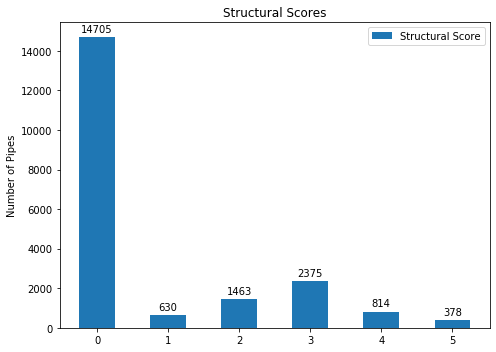

In [70]:
##Number of pipes by Ops Score
labels = list(sscore.index)
values = list(sscore)

x = np.arange(len(labels))  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots(figsize=(7, 5))
rects1 = ax.bar(x, values, width, label='Structural Score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Pipes')
ax.set_title('Structural Scores')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
fig.tight_layout()
plt.show()

In [86]:
##OPSCORE
opscore = result['MAXOPSMAINTSCORE'].value_counts().sort_index()
print (opscore)

0    10395
1     4367
2     1842
3     2674
4      928
5      159
Name: MAXOPSMAINTSCORE, dtype: int64


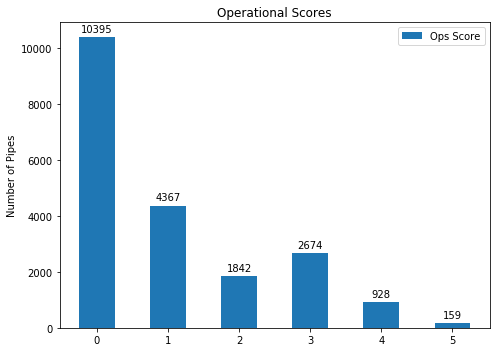

In [87]:
##Number of pipes by Ops Score
labels = list(opscore.index)
values = list(opscore)

x = np.arange(len(labels))  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots(figsize=(7, 5))
rects1 = ax.bar(x, values, width, label='Ops Score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Pipes')
ax.set_title('Operational Scores')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
fig.tight_layout()
plt.show()

In [40]:
##MATERIAL
material = result['MATERIAL'].value_counts()
print (material)

VCP    14351
PVC     2193
RCP     1804
CP       726
UNK      508
AC       255
CT       166
SP       113
CMP       91
PE        48
CAS       30
FRP       28
RPM       24
PSC       14
PP         6
DIP        4
CSU        2
ABS        1
GP         1
Name: MATERIAL, dtype: int64


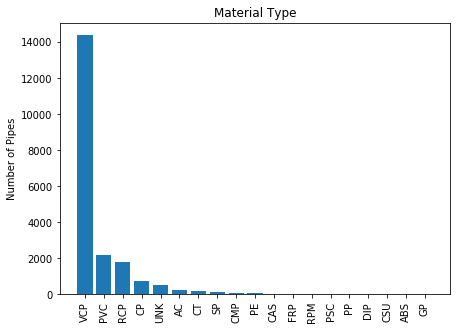

In [85]:
#Materials bar chart
labels = list(material.index)
x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(7, 5))
plt.bar(material.index,material)
plt.xticks(x, labels, rotation='vertical')
ax.set_ylabel('Number of Pipes')
ax.set_title('Material Type')

plt.show()

In [102]:
##SYSTEM
system = result['GRP_SYSTEM'].value_counts()
print (system)

S    11802
C     4704
D     3859
Name: GRP_SYSTEM, dtype: int64


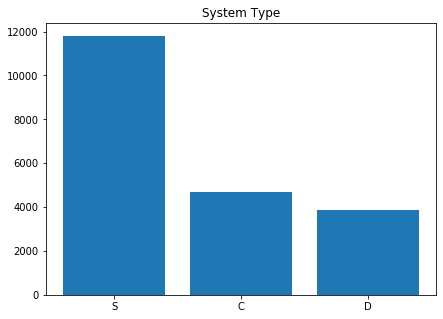

In [104]:
fig, ax = plt.subplots(figsize=(7, 5))
plt.bar(system.index,system)
ax.set_title('System Type')
plt.show()

In [34]:
##DIAMETER
#Some of these pipe diameters with only one count are probably mislabeled
diameter = result['DIAMETER'].value_counts().sort_index()
print (diameter.head())
print(len(diameter))

4      66
5       1
6    7481
7       1
8    5194
Name: DIAMETER, dtype: int64
48


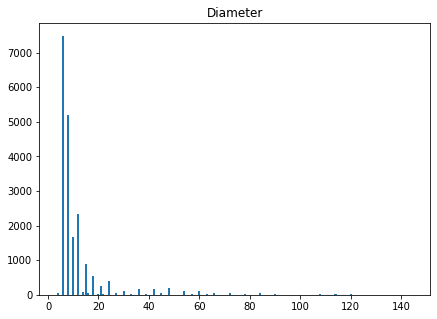

In [35]:
fig, ax = plt.subplots(figsize=(7, 5))
plt.bar(diameter.index,diameter)
#plt.hist(diameter, bins=5)
ax.set_title('Diameter')
plt.show()

In [120]:
##SHAPELENGTH
shplength = result['SHAPELENGTH'].value_counts().sort_index()
print (shplength)

4        2
5        3
6        4
7       11
8       11
        ..
1210     1
1312     1
1404     1
2795     1
2807     1
Name: SHAPELENGTH, Length: 703, dtype: int64


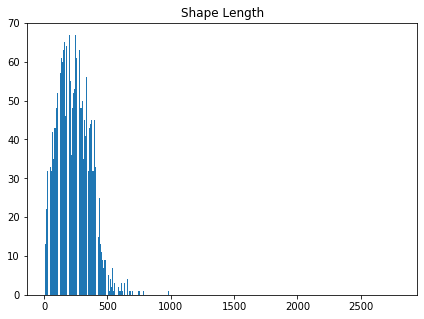

In [122]:
fig, ax = plt.subplots(figsize=(7, 5))
plt.bar(shplength.index,shplength)
plt.ylim(0, 70)
ax.set_title('Shape Length')
plt.show()

In [123]:
##AGE
age = result['AGE'].value_counts().sort_index()
print(age)

1        3
2       17
3       43
4       20
5      128
      ... 
129      4
131      9
132     31
134      1
135     16
Name: AGE, Length: 129, dtype: int64


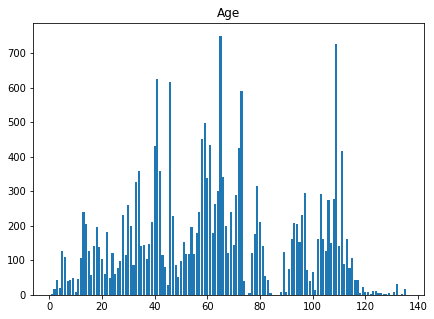

In [125]:
fig, ax = plt.subplots(figsize=(7, 5))
plt.bar(age.index,age)
ax.set_title('Age')
plt.show()

In [262]:
##Correlation coefficients for variables and MSS
correlation = result.corr().round(2)
correlation.drop('SURVEYEDFOOTAGE',axis = 1,inplace=True)
correlation.drop('SURVEYEDFOOTAGE',inplace=True)
correlation

,DIAMETER,SHAPELENGTH,AGE,MAXOPSMAINTSCORE,MAXSTRUCTURALSCORE
DIAMETER,1.00,0.10,-0.02,0.07,0.08
SHAPELENGTH,0.10,1.00,0.03,0.19,0.15
AGE,-0.02,0.03,1.00,0.25,0.36
MAXOPSMAINTSCORE,0.07,0.19,0.25,1.00,0.25
MAXSTRUCTURALSCORE,0.08,0.15,0.36,0.25,1.00


In [37]:
#Ops score for CMP Pipes
CMP = result[result['MATERIAL']=='CMP']
print (len(CMP))
CMP.head()

91


,SYSTEM,DIAMETER,MATERIAL,SHAPELENGTH,SURVEYEDFOOTAGE,AGE,MAXOPSMAINTSCORE,MAXSTRUCTURALSCORE,GRP_SYSTEM
FACILITYID,,,,,,,,,
20236,S,12,CMP,76,40.7,55,0,0,S
3760,S,10,CMP,465,461.0,42,0,0,S
4366,S,8,CMP,447,448.0,42,0,0,S
67558,S,10,CMP,24,19.4,65,0,0,S
19183,S,24,CMP,435,463.3,79,1,2,S


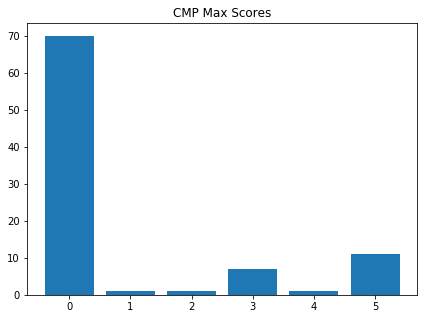

In [38]:
CMP_mss = CMP['MAXSTRUCTURALSCORE'].value_counts()
fig, ax = plt.subplots(figsize=(7, 5))
plt.bar(CMP_mss.index,CMP_mss)
ax.set_title('CMP Max Scores')
plt.show()

In [163]:
#Count of MSS by Material Type
c = result[['MAXSTRUCTURALSCORE','MATERIAL','MAXOPSMAINTSCORE']].groupby('MATERIAL').mean().sort_values('MAXSTRUCTURALSCORE', ascending=False)
c.head(20)

,MAXSTRUCTURALSCORE,MAXOPSMAINTSCORE
MATERIAL,,
SP,1.415929,0.849558
ABS,1.000000,0.000000
CMP,0.912088,0.373626
VCP,0.893178,1.167724
RCP,0.869734,1.063747
CAS,0.833333,1.733333
UNK,0.761811,0.653543
CT,0.668675,1.102410
CP,0.400826,0.516529


In [150]:
result.groupby(['MAXSTRUCTURALSCORE','MATERIAL']).size()

MAXSTRUCTURALSCORE  MATERIAL
0                   AC          234
                    CAS          21
                    CMP          70
                    CP          623
                    CSU           2
                               ... 
5                   PVC          12
                    RCP          67
                    SP            2
                    UNK          25
                    VCP         228
Length: 68, dtype: int64

In [41]:
#Update Material column with "Other" value to prepare for encoding
mlist = (list(material[material<50].index))
mlist

['PE', 'CAS', 'FRP', 'RPM', 'PSC', 'PP', 'DIP', 'CSU', 'ABS', 'GP']

In [42]:
result['MATERIAL'].replace(mlist, 'Other', inplace=True)

In [43]:
material = result['MATERIAL'].value_counts()
print (material)

VCP      14351
PVC       2193
RCP       1804
CP         726
UNK        508
AC         255
CT         166
Other      158
SP         113
CMP         91
Name: MATERIAL, dtype: int64


# **Analysis:**

In [44]:
variables = ['DIAMETER','SHAPELENGTH','AGE','MAXOPSMAINTSCORE','MATERIAL', 'GRP_SYSTEM','MAXSTRUCTURALSCORE']
clean_data = result[variables].copy()
print (len(clean_data))
clean_data.reset_index(inplace=True)
clean_data.head()

20365


,FACILITYID,DIAMETER,SHAPELENGTH,AGE,MAXOPSMAINTSCORE,MATERIAL,GRP_SYSTEM,MAXSTRUCTURALSCORE
0,19341,6,185,109,0,VCP,S,5
1,18859,6,258,47,0,VCP,S,5
2,20561,6,370,109,0,VCP,S,5
3,20035,8,85,65,0,VCP,S,5
4,20380,6,296,6,0,VCP,S,5


**One Hot Encoding - Categorical Attributes**

In [45]:
#Import Encoders
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [46]:
#Encode System Type
sys_le = LabelEncoder()
sys_labels = sys_le.fit_transform(clean_data['GRP_SYSTEM'])
clean_data['Sys_Label'] = sys_labels

In [47]:
#Check Labels
print(clean_data['Sys_Label'].value_counts())
print(clean_data['GRP_SYSTEM'].value_counts())
clean_data.head()

2    11802
0     4704
1     3859
Name: Sys_Label, dtype: int64
S    11802
C     4704
D     3859
Name: GRP_SYSTEM, dtype: int64


,FACILITYID,DIAMETER,SHAPELENGTH,AGE,MAXOPSMAINTSCORE,MATERIAL,GRP_SYSTEM,MAXSTRUCTURALSCORE,Sys_Label
0,19341,6,185,109,0,VCP,S,5,2
1,18859,6,258,47,0,VCP,S,5,2
2,20561,6,370,109,0,VCP,S,5,2
3,20035,8,85,65,0,VCP,S,5,2
4,20380,6,296,6,0,VCP,S,5,2


In [48]:
#One Hot Encode System Type
sys_ohe = OneHotEncoder()
sys_feature_arr = sys_ohe.fit_transform(
                              clean_data[['Sys_Label']]).toarray()
sys_feature_labels = list(sys_le.classes_)
sys_features = pd.DataFrame(sys_feature_arr, 
                            columns=sys_feature_labels)

In [49]:
#Encode Material Type
m_le = LabelEncoder()
m_labels = m_le.fit_transform(clean_data['MATERIAL'])
clean_data['Mat_Label'] = m_labels

In [214]:
#Check Labels
print(clean_data['Mat_Label'].value_counts().sort_index())
print(clean_data['MATERIAL'].value_counts().sort_index())
clean_data.head()

0      255
1       91
2      726
3      166
4      158
5     2193
6     1804
7      113
8      508
9    14351
Name: Mat_Label, dtype: int64
AC         255
CMP         91
CP         726
CT         166
Other      158
PVC       2193
RCP       1804
SP         113
UNK        508
VCP      14351
Name: MATERIAL, dtype: int64


,FACILITYID,DIAMETER,SHAPELENGTH,AGE,MAXOPSMAINTSCORE,MATERIAL,GRP_SYSTEM,MAXSTRUCTURALSCORE,Sys_Label,Mat_Label
0,19341,6,185,109,0,VCP,S,5,2,9
1,18859,6,258,47,0,VCP,S,5,2,9
2,20561,6,370,109,0,VCP,S,5,2,9
3,20035,8,85,65,0,VCP,S,5,2,9
4,20380,6,296,6,0,VCP,S,5,2,9


In [50]:
#One Hot Encode Material Type
m_ohe = OneHotEncoder()
m_feature_arr = m_ohe.fit_transform(
                              clean_data[['Mat_Label']]).toarray()
m_feature_labels = list(m_le.classes_)
m_features = pd.DataFrame(m_feature_arr, 
                            columns=m_feature_labels)

In [51]:
data_ohe = pd.concat([clean_data, sys_features, m_features],sort=False,axis=1)

In [52]:
data_ohe.columns

Index(['FACILITYID', 'DIAMETER', 'SHAPELENGTH', 'AGE', 'MAXOPSMAINTSCORE',
       'MATERIAL', 'GRP_SYSTEM', 'MAXSTRUCTURALSCORE', 'Sys_Label',
       'Mat_Label', 'C', 'D', 'S', 'AC', 'CMP', 'CP', 'CT', 'Other', 'PVC',
       'RCP', 'SP', 'UNK', 'VCP'],
      dtype='object')

In [53]:
data_ohe.head()

,FACILITYID,DIAMETER,SHAPELENGTH,AGE,MAXOPSMAINTSCORE,MATERIAL,GRP_SYSTEM,MAXSTRUCTURALSCORE,Sys_Label,Mat_Label,...,AC,CMP,CP,CT,Other,PVC,RCP,SP,UNK,VCP
0,19341,6,185,109,0,VCP,S,5,2,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,18859,6,258,47,0,VCP,S,5,2,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,20561,6,370,109,0,VCP,S,5,2,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,20035,8,85,65,0,VCP,S,5,2,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,20380,6,296,6,0,VCP,S,5,2,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [54]:
y=data_ohe[['MAXSTRUCTURALSCORE']].copy()
y

,MAXSTRUCTURALSCORE
0,5
1,5
2,5
3,5
4,5
...,...
20360,0
20361,0
20362,0
20363,0


In [55]:
variables = ['DIAMETER', 'SHAPELENGTH', 'AGE', 'MAXOPSMAINTSCORE', 'C', 'D', 'S', 'AC', 'CMP', 'CP', 'CT', 'Other', 'PVC','RCP', 'SP', 'UNK', 'VCP']

In [56]:
x = data_ohe[variables].copy()
x

,DIAMETER,SHAPELENGTH,AGE,MAXOPSMAINTSCORE,C,D,S,AC,CMP,CP,CT,Other,PVC,RCP,SP,UNK,VCP
0,6,185,109,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,6,258,47,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,6,370,109,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,8,85,65,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,6,296,6,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20360,8,155,102,5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
20361,114,235,105,5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
20362,48,686,79,5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
20363,8,181,114,5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Begin Classification

In [57]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=100)

In [69]:
x_train.tail()
#y_train.describe()

,DIAMETER,SHAPELENGTH,AGE,MAXOPSMAINTSCORE,C,D,S,AC,CMP,CP,CT,Other,PVC,RCP,SP,UNK,VCP
16304,24,16,6,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
79,12,322,79,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12119,12,260,54,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
14147,12,159,28,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5640,6,269,29,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [59]:
y_train

,MAXSTRUCTURALSCORE
4125,0
758,1
1143,0
6862,0
8784,1
...,...
16304,0
79,4
12119,0
14147,0


In [60]:
#Criterion=entropy increases accuracy by .1%
mss_classifier = DecisionTreeClassifier(max_leaf_nodes=10, random_state=0, criterion="entropy")
mss_classifier.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=10,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [61]:
predictions = mss_classifier.predict(x_test)

In [62]:
predictions[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [63]:
accuracy_score(y_true = y_test, y_pred = predictions)

0.7214700193423598

In [64]:
y_test['MAXSTRUCTURALSCORE'].value_counts()

0    4778
3     807
2     492
4     295
1     206
5     143
Name: MAXSTRUCTURALSCORE, dtype: int64

In [65]:
predictions_df = pd.DataFrame({'A':predictions})
predictions_df['A'].value_counts()

0    6568
3     153
Name: A, dtype: int64

**Try Feature Hashing for Material**

In [106]:
from sklearn.feature_extraction import FeatureHasher

In [145]:
fh = FeatureHasher(n_features=5, input_type='string')
hashed_features = fh.fit_transform(clean_data['MATERIAL'])
hashed_features = hashed_features.toarray()
pd.concat([clean_data[['MATERIAL']], pd.DataFrame(hashed_features)], axis=1)

,MATERIAL,0,1,2,3,4
0,VCP,0.0,-2.0,0.0,0.0,1.0
1,VCP,0.0,-2.0,0.0,0.0,1.0
2,VCP,0.0,-2.0,0.0,0.0,1.0
3,VCP,0.0,-2.0,0.0,0.0,1.0
4,VCP,0.0,-2.0,0.0,0.0,1.0
...,...,...,...,...,...,...
20360,VCP,0.0,-2.0,0.0,0.0,1.0
20361,RCP,0.0,-2.0,0.0,0.0,1.0
20362,RCP,0.0,-2.0,0.0,0.0,1.0
20363,VCP,0.0,-2.0,0.0,0.0,1.0


In [146]:
data_fh = pd.concat([clean_data, sys_features, pd.DataFrame(hashed_features)],sort=False,axis=1)

In [147]:
print (list(data_fh.columns))

['FACILITYID', 'DIAMETER', 'SHAPELENGTH', 'AGE', 'MAXOPSMAINTSCORE', 'MATERIAL', 'GRP_SYSTEM', 'MAXSTRUCTURALSCORE', 'C', 'D', 'S', 0, 1, 2, 3, 4]


In [175]:
variables2 = ['DIAMETER', 'SHAPELENGTH', 'AGE', 'MAXOPSMAINTSCORE', 'C', 'D', 'S',0, 1, 2, 3, 4]
x2 = data_fh[variables2].copy()

In [176]:
x2

,DIAMETER,SHAPELENGTH,AGE,MAXOPSMAINTSCORE,C,D,S,0,1,2,3,4
0,6,185,109,0,0.0,0.0,1.0,0.0,-2.0,0.0,0.0,1.0
1,6,258,47,0,0.0,0.0,1.0,0.0,-2.0,0.0,0.0,1.0
2,6,370,109,0,0.0,0.0,1.0,0.0,-2.0,0.0,0.0,1.0
3,8,85,65,0,0.0,0.0,1.0,0.0,-2.0,0.0,0.0,1.0
4,6,296,6,0,0.0,0.0,1.0,0.0,-2.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
20360,8,155,102,5,1.0,0.0,0.0,0.0,-2.0,0.0,0.0,1.0
20361,114,235,105,5,1.0,0.0,0.0,0.0,-2.0,0.0,0.0,1.0
20362,48,686,79,5,1.0,0.0,0.0,0.0,-2.0,0.0,0.0,1.0
20363,8,181,114,5,1.0,0.0,0.0,0.0,-2.0,0.0,0.0,1.0


In [182]:
y

,MAXSTRUCTURALSCORE
0,5
1,5
2,5
3,5
4,5
...,...
20360,0
20361,0
20362,0
20363,0


In [183]:
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y, test_size=0.33, random_state=100)

In [206]:
mss_classifier_fh = DecisionTreeClassifier(max_leaf_nodes=10, random_state=0, criterion="entropy")
mss_classifier_fh.fit(x2_train, y2_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=10,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [207]:
predictions2 = mss_classifier_fh.predict(x2_test)

In [209]:
accuracy_score(y_true = y2_test, y_pred = predictions2)
#accuracy is the same for one hot encoding and feature hashing?!

0.7214700193423598

# Visualizations

Is the classifier predicting high scores well?

In [ ]:
import plotly.graph_objects as go

In [99]:
p = pd.DataFrame(predictions, columns=['prediction'])

In [79]:
y_test_vis=y_test.reset_index()

In [84]:
y_test_vis.drop(['index'], axis=1,inplace=True)

In [100]:
vis = pd.concat([p,y_test_vis], axis=1)
vis

,prediction,MAXSTRUCTURALSCORE
0,0,4
1,0,2
2,0,1
3,0,1
4,0,0
...,...,...
6716,0,3
6717,0,0
6718,0,3
6719,0,0


In [88]:
p['prediction'].value_counts()

0    6568
3     153
Name: 0, dtype: int64

In [89]:
y_test_vis['MAXSTRUCTURALSCORE'].value_counts()

0    4778
3     807
2     492
4     295
1     206
5     143
Name: MAXSTRUCTURALSCORE, dtype: int64

In [110]:
#Add column if prediction correct or not
vis.loc[(vis['prediction'] == vis['MAXSTRUCTURALSCORE']),'Correct'] = 1
vis.loc[(vis['prediction'] != vis['MAXSTRUCTURALSCORE']),'Incorrect'] = 1

In [111]:
vis

,prediction,MAXSTRUCTURALSCORE,Correct,Incorrect
0,0,4,0.0,1.0
1,0,2,0.0,1.0
2,0,1,0.0,1.0
3,0,1,0.0,1.0
4,0,0,1.0,NaN
...,...,...,...,...
6716,0,3,0.0,1.0
6717,0,0,1.0,NaN
6718,0,3,0.0,1.0
6719,0,0,1.0,NaN


In [118]:
#Group by for visualization
vis_pred = vis[['MAXSTRUCTURALSCORE','Correct','Incorrect']].groupby('MAXSTRUCTURALSCORE').sum()
vis_pred.Incorrect = vis_pred.Incorrect.astype(int, errors='ignore')

,Correct,Incorrect
MAXSTRUCTURALSCORE,,
0,4756,22
1,0,206
2,0,492
3,93,714
4,0,295
5,0,143


In [144]:
vis_pred['P_Correct']= round(100*(vis_pred['Correct']/(vis_pred['Correct']+vis_pred['Incorrect'])),1)
vis_pred['P_Incorrect'] = 100-vis_pred['P_Correct']
vis_pred

,Correct,Incorrect,P_Correct,P_Incorrect
MAXSTRUCTURALSCORE,,,,
0,4756,22,99.5,0.5
1,0,206,0.0,100.0
2,0,492,0.0,100.0
3,93,714,11.5,88.5
4,0,295,0.0,100.0
5,0,143,0.0,100.0


In [123]:
vis_pred['Correct'].values

array([4756,    0,    0,   93,    0,    0])

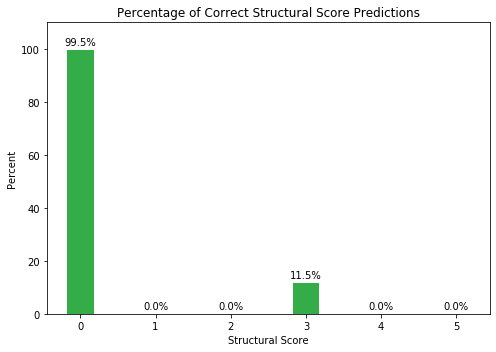

In [185]:
labels = list(vis_pred.index)
corr = vis_pred['P_Correct'].values
incorr = vis_pred['P_Incorrect'].values

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(7,5))
rects1 = ax.bar(x, corr, width, label='Correct', color = '#34ad48')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percent')
ax.set_xlabel('Structural Score')
ax.set_title('Percentage of Correct Structural Score Predictions')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(top=110)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}%'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

autolabel(rects1)

fig.tight_layout()

plt.show()

In [202]:
#Bubble Graph for 4s and 5s
#age = x axis, material = color, diameter, ops score = bubble size,
variables = ['DIAMETER','SHAPELENGTH','AGE','MAXOPSMAINTSCORE','MATERIAL','MAXSTRUCTURALSCORE','Mat_Label']
vis_bubb = clean_data[variables].copy()
vis_bubb = vis_bubb[(vis_bubb['MAXSTRUCTURALSCORE']==4) | (vis_bubb['MAXSTRUCTURALSCORE']==5)]
vis_bubb

,DIAMETER,SHAPELENGTH,AGE,MAXOPSMAINTSCORE,MATERIAL,MAXSTRUCTURALSCORE,Mat_Label
0,6,185,109,0,VCP,5,9
1,6,258,47,0,VCP,5,9
2,6,370,109,0,VCP,5,9
3,8,85,65,0,VCP,5,9
4,6,296,6,0,VCP,5,9
...,...,...,...,...,...,...,...
20284,10,17,92,5,VCP,5,9
20285,8,53,96,5,VCP,5,9
20286,63,541,104,5,RCP,5,6
20287,8,199,109,5,VCP,4,9


In [264]:
#Bubble Graph for 4s and 5s
#age = x axis, material = color, diameter, ops score = bubble size,
variables = ['DIAMETER','AGE','MAXSTRUCTURALSCORE']
vis_bubb2 = clean_data[variables].copy()
vis_bubb2

,DIAMETER,AGE,MAXSTRUCTURALSCORE
0,6,109,5
1,6,47,5
2,6,109,5
3,8,65,5
4,6,6,5
...,...,...,...
20360,8,102,0
20361,114,105,0
20362,48,79,0
20363,8,114,0


In [272]:
msslist = list(vis_bubb2['MAXSTRUCTURALSCORE'])
colorlist = []
for val in msslist:
    x = ''
    if val == 0:
        x = 'rgb(0, 130, 200)'
    elif val ==1:
        x = 'rgb(60, 180, 75)'
    elif val ==2:
        x = 'rgb(210, 245, 60)'
    elif val ==3:
        x = 'rgb(255, 225, 25)'
    elif val ==4:
        x = 'rgb(245, 130, 48)'
    else:
        x = 'rgb(230, 25, 75)'
    colorlist.append(x)

In [274]:
fig = go.Figure()

#Structural Score distribution:
fig.add_trace(go.Scatter(
    x=vis_bubb2['AGE'], y=vis_bubb2['DIAMETER'],
    mode='markers',
    marker=dict(color=colorlist)
    ))

fig.update_layout(
    title='Structural Scores by Age and Diameter',
    xaxis=dict(
        title='Age',
        gridcolor='white',
        gridwidth=2,
    ),
    yaxis=dict(
        title='Diameter',
        gridcolor='white',
        gridwidth=2,
    ),
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
)

fig.show()

In [226]:
#Distribution of predictions and y_test
a = predictions_df['A'].value_counts()

In [227]:
b = y_test['MAXSTRUCTURALSCORE'].value_counts().sort_index()

In [246]:
vis_pred2 = pd.concat([a,b],axis=1)
vis_pred2.rename(columns={"A": "Prediction", "MAXSTRUCTURALSCORE": "Actual"},inplace=True)
vis_pred2.fillna(0, inplace=True)
vis_pred2.Prediction = vis_pred2.Prediction.astype(int, errors='ignore')
vis_pred2

,Prediction,Actual
0,6568,4778
1,0,206
2,0,492
3,153,807
4,0,295
5,0,143


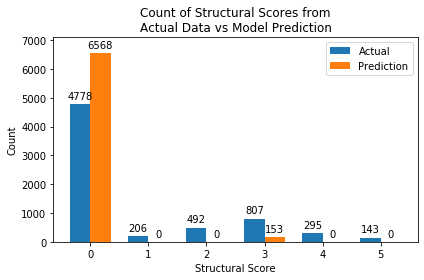

In [277]:
labels = list(vis_pred2.index)
pred = vis_pred2['Prediction'].values
actual = vis_pred2['Actual'].values

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, actual, width, label='Actual')
rects2 = ax.bar(x + width/2, pred, width, label='Prediction')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_xlabel('Structural Score')
ax.set_title('Count of Structural Scores from\nActual Data vs Model Prediction')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim(top=7100)


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height),0),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()